## <center>Анализ аварий на ЖД транспорте США в 2013 году 
## <center>и страховых выплат по ним
<div style="border: 2px solid black; margin-left: 15%; margin-right: 15%"><img style="" src='https://www.atsb.gov.au/media/2444492/ro2010012_fig1.jpg' /></div>

### 1. Описание набора данных и признаков

В этом проекте исследуются данные об инцидентах грузового железнодорожного транспорта США за 2013 год и соответствующие запросы на страховое возмещение ущербра от перевозчиков. Данные взяты с <a href="http://www.explore-support.com/help/sample-data-sets">Cisco Data Explore</a>.

Датасет содержит следующие признаки:
<table class='desc_table' align='left' width='100%'>
<tr><th style="text-align: left !important">Признак</th><th style="text-align: left !important">Описание</th></tr>
<tr>
<td style="text-align: left !important">DEPARTURE CITY</td>
<td style="text-align: left !important">Город отправления груза (вагона)</td>
</tr>
<tr>
<td style="text-align: left !important">DEPARTURE STATE</td>
<td style="text-align: left !important">Штат отправления груза (вагона)</td>
</tr>
<tr>
<td style="text-align: left !important">DEPARTURE CARRIER</td>
<td style="text-align: left !important">Перевозчик отправления, отправитель</td>
</tr>
<tr>
<td style="text-align: left !important">ARRIVAL CITY</td>
<td style="text-align: left !important">Город прибытия груза (вагона)</td>
</tr>
<tr>
<td style="text-align: left !important">ARRIVAL STATE</td>
<td style="text-align: left !important">Штат прибытия груза (вагона)</td>
</tr>
<tr>
<td style="text-align: left !important">ARRIVAL CARRIER</td>
<td style="text-align: left !important">Компания-перевозчик прибытия, принимающая сторона</td>
</tr>
<tr>
<td style="text-align: left !important">RAIL SPEED SPEED</td>
<td style="text-align: left !important">Тип скороcти железной дороги</td>
</tr>
<tr>
<td style="text-align: left !important">RAIL CAR TYPE TYPE</td>
<td style="text-align: left !important">Тип вагона</td>
</tr>
<tr>
<td style="text-align: left !important">RAIL OWNERSHIP OWNERSHIP</td>
<td style="text-align: left !important">Тип собственности железной дороги</td>
</tr>
<tr>
<td style="text-align: left !important">RAIL CARLOAD LOAD</td>
<td style="text-align: left !important">Тип груза</td>
</tr>
<tr>
<td style="text-align: left !important">DEPEARTURE DATE</td>
<td style="text-align: left !important">Дата отправления</td>
</tr>
<tr>
<td style="text-align: left !important">ARRIVAL DATE</td>
<td style="text-align: left !important">Дата прибытия</td>
</tr>
<tr>
<td style="text-align: left !important">CAR VALUE</td>
<td style="text-align: left !important">Стоимость вагона, USD</td>
</tr>
<tr>
    <td style="text-align: left !important"><b>DAMAGED</b></td>
<td style="text-align: left !important"><b>Размер ущерба, USD</b></td>
</tr>
<tr>
<td style="text-align: left !important">WEIGHT</td>
<td style="text-align: left !important">Вес груза</td>
</tr>
<tr>
<td style="text-align: left !important">FUEL USED</td>
<td style="text-align: left !important">Количествто израсходованного топлива</td>
</tr>
<tr>
<td style="text-align: left !important">PROPER DESTINATION</td>
<td style="text-align: left !important">Метка правильности назначения</td>
</tr>
<tr>
<td style="text-align: left !important">MILES</td>
<td style="text-align: left !important">Пройденный путь</td>
</tr>
<tr>
<td style="text-align: left !important"># OF STOPS</td>
<td style="text-align: left !important">Количество остановок в пути</td>
</tr>
</table>

<b>Задача данного пректа</b> - попытаться предсказать размер ущерба, полученного в результате инцидента, а также предоставить другую полезную информацию. 

<b>Ценность результатов проекта</b> - информация для страховых компаний, позволяющая быть более гибкими в расчете стоимости страховки для тех или иных компаний, грузов, направлений и т. д., а также для самих перевозчиков - для прогноза затрат на перевозку грузов, выбора более безопасных путей, времени и других параметров для транспортировки грузов.

### 2. Первичный анализ данных

Импортируем все нужные библиотеки:

In [86]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score

from sklearn.linear_model import LogisticRegression, LinearRegression
import xgboost as xgb

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

Теперь посмотрим на наши данные:

In [87]:
data_file = '../../data/Rail_Insurance_Claims.csv'
data = pd.read_csv(data_file, sep=',', parse_dates=['DEPEARTURE DATE','ARRIVAL DATE'])

In [88]:
data.head()

,DEPARTURE CITY,DEPARTURE STATE,DEPARTURE CARRIER,ARRIVAL CITY,ARRIVAL STATE,ARRIVAL CARRIER,RAIL SPEED SPEED,RAIL CAR TYPE TYPE,RAIL OWNERSHIP OWNERSHIP,RAIL CARLOAD LOAD,DEPEARTURE DATE,ARRIVAL DATE,CAR VALUE,DAMAGED,WEIGHT,FUEL USED,PROPER DESTINATION,MILES,# OF STOPS
0,Kansas City,MO,UP,Kansas City,MO,KCS,Coal Unit,Box,Foreign,Coal,2013-05-27,2013-06-15,247882,3379.096242,0,33.771459,No,1959,4
1,Hinkle,OR,UP,Laredo,TX,KCS,Grain Unit,Box,Foreign,Intermodal,2013-10-18,2013-10-31,155181,3364.134687,0,33.369887,No,2070,4
2,Pasco,WA,BNSF,Columbus,OH,NS,Multilevel,Box,System,Metallic Ores and Metals,2013-09-21,2013-09-29,203772,10196.383910,0,44.481937,No,1668,4
3,Willard,OH,CSX,Nashville,TN,CSX,Coal Unit,Box,Private,"Farm and Food Products, Excluding Grain",2013-05-01,2013-05-14,76478,1256.560688,0,38.505788,No,1278,1
4,Nashville,TN,CSX,Laredo,TX,KCS,Intermodal,Box,Foreign,Intermodal,2013-03-03,2013-03-18,194439,126168.938500,0,45.547588,No,267,5


In [89]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10321 entries, 0 to 10320
Data columns (total 19 columns):
DEPARTURE CITY              10321 non-null object
DEPARTURE STATE             10321 non-null object
DEPARTURE CARRIER           10321 non-null object
ARRIVAL CITY                10321 non-null object
ARRIVAL STATE               10321 non-null object
ARRIVAL CARRIER             10321 non-null object
RAIL SPEED SPEED            10321 non-null object
RAIL CAR TYPE TYPE          10321 non-null object
RAIL OWNERSHIP OWNERSHIP    10321 non-null object
RAIL CARLOAD LOAD           10321 non-null object
DEPEARTURE DATE             10321 non-null datetime64[ns]
ARRIVAL DATE                10321 non-null datetime64[ns]
CAR VALUE                   10321 non-null int64
DAMAGED                     10321 non-null float64
WEIGHT                      10321 non-null int64
FUEL USED                   10321 non-null float64
PROPER DESTINATION          10321 non-null object
MILES                    

In [90]:
data.describe()

,CAR VALUE,DAMAGED,WEIGHT,FUEL USED,MILES,# OF STOPS
count,10321.000000,10321.000000,10321.000000,10321.000000,10321.000000,10321.000000
mean,162579.346963,10853.728520,131.281465,41.339406,1199.967542,3.012499
std,50376.229618,24929.021573,45.847159,11.529142,579.683252,2.012543
min,75011.000000,0.831794,0.000000,18.904175,200.000000,0.000000
25%,118878.000000,2423.730795,102.000000,31.795090,691.000000,1.000000
50%,162781.000000,4785.356963,135.000000,41.003229,1199.000000,3.000000
75%,205951.000000,8133.537099,167.000000,50.216322,1704.000000,4.000000
max,249979.000000,239397.366700,200.000000,69.941356,2200.000000,9.000000


In [91]:
data.describe(include=['object'])

,DEPARTURE CITY,DEPARTURE STATE,DEPARTURE CARRIER,ARRIVAL CITY,ARRIVAL STATE,ARRIVAL CARRIER,RAIL SPEED SPEED,RAIL CAR TYPE TYPE,RAIL OWNERSHIP OWNERSHIP,RAIL CARLOAD LOAD,PROPER DESTINATION
count,10321,10321,10321,10321,10321,10321,10321,10321,10321,10321,10321
unique,62,28,7,62,28,7,5,7,3,11,2
top,Kansas City,IL,CSX,Kansas City,TX,CSX,Intermodal,Multilevel,Private,Intermodal,Yes
freq,468,931,2391,463,961,2321,2126,1509,3453,4888,10005


In [92]:
data.describe(include='datetime64')

,DEPEARTURE DATE,ARRIVAL DATE
count,10321,10321
unique,364,377
top,2013-01-04 00:00:00,2013-12-08 00:00:00
freq,47,44
first,2013-01-01 00:00:00,2013-01-08 00:00:00
last,2013-12-30 00:00:00,2014-01-20 00:00:00


Видим, что в датасете большинство признаков - категориальные, целевая переменная и кол-во топлива - вещественные, два временных признака и несколько количественных. В данных нет пропусков. Также в данных есть много парных признаков DEPARTURE и ARRIVAL. Отсюда можно сделать следующие промежуточные выводы:
 * Категориальные признаки понадобится кодировать (OHE, mean target)
 * Из парных признаков можно извлечь много дополинтельной информации и создать новые признаки, связанные с путем следования, временем в пути и т.д.
 * В данных на первый взгляд нет пропусков - нужно проверить значения категориальных признаков на смысловые пропуски: значения типа N/A, unknown и т. д.
 * Из числовых признаков можно создать новые относительные.
 * Из временных признаков также можно извлечь дополнительную информацию
 * В данных присутствуют признаки CAR VALUE и DAMAGED - целесообразно предсказывать не сам ущерб, а его процент
 

In [93]:
data['damaged percent'] = data['DAMAGED'] / data['CAR VALUE']
data['damaged percent'].describe()

count    10321.000000
mean         0.067444
std          0.148077
min          0.000009
25%          0.016603
50%          0.032715
75%          0.049130
max          0.959328
Name: damaged percent, dtype: float64

Видим, что значения находятся в интервали от 0 до 1, т.е. признак корректный. Также можно заметить, что 75-я квантиль на порядок меньше максимального значения, из чего можно сделать вывод, что целевая переменная имееть сильный дисбаланс.

Посмотрим на распределения категориальных признаков и целевой переменной: построим несколько pivot-таблиц по категориальным признакам.

In [94]:
(data.pivot_table( ['damaged percent'], ['DEPARTURE STATE'], ['ARRIVAL STATE'],  aggfunc='mean')) * 100

damaged percent                                              \
ARRIVAL STATE                AL         AR         CA         CO         GA   
DEPARTURE STATE                                                               
AL                     3.496112   3.643584   2.386319   3.058723   2.288345   
AR                     3.367710   3.090576   3.246182   3.555704   4.055410   
CA                     3.256903   2.483677   2.712727   3.770990   3.250525   
CO                     1.594926   3.777130   3.188697   3.179968        NaN   
GA                     3.061058   3.209844   2.949345   2.012123   2.589015   
IL                     3.155626   3.235374   3.050773   3.440171   2.686508   
IN                     2.537008   3.124931   2.921129   2.042961   3.486988   
KS                     2.865380   2.936357   3.452167   3.335309   2.249868   
KY                     3.195893   2.949378   3.094132   2.703832   3.498217   
LA                     2.558315   2.675865   3.082562   1.693604   3.515725   
MD                     2.173832   2.672957   3.046420   3.237607   1.774133   
MN                     2.767655   3.243956   3.524130   1.819691   3.282204   
MO                     2.576833   3.805379   3.371165   3.653577   3.904117   
MS                     3.095924   1.525077   3.047249   2.698642   2.499698   
NC                     3.205648   2.936753   3.355239   2.735183   3.175034   
NE                     2.904078   2.445543   3.080036   4.718355   3.453661   
NL                     3.770655   4.096912   3.277219   5.162611   3.857891   
NY                     3.687602   2.912870   2.914388   2.678026   3.972960   
OH                     3.152382   2.432937   3.227249   3.382515   3.559651   
OK                     3.941444   2.291629   2.879035   3.710044   2.550301   
OR                     2.592651   3.035763   2.524960   4.888777   2.089353   
PA                     2.700646   2.703638   2.078576   3.285475   2.567833   
PQ                     3.702178   4.568634   3.404148   1.413091   3.230306   
TN                    40.554273  61.333975  46.103644  51.468357  49.576347   
TX                     3.396199   3.486083   2.473977   3.666703   3.236445   
VA                     3.572085   2.792473   4.059000   3.299903   2.885408   
WA                     2.877503   2.746176   3.021220   3.062682   2.381829   
WI                     2.634596   1.845658   3.456816   2.101467   3.403658   

                                                                        \
ARRIVAL STATE           IL         IN         KS         KY         LA   
DEPARTURE STATE                                                          
AL                3.160479   2.411636   3.641065   2.600097   3.040437   
AR                3.050455   2.394722   2.359201   2.910230   2.755787   
CA                3.117571   3.930794   2.555485   3.376924   2.636809   
CO                2.947829   3.055759   4.017544   3.639419   3.666488   
GA                2.972747   2.766935   1.922825   3.792717   3.420114   
IL                3.373077   2.624725   3.592280   2.886199   2.964780   
IN                3.078768   2.986675   3.868794   3.871977   2.846601   
KS                2.703918   3.173504   4.125379   3.758306   4.069150   
KY                2.978770   2.689055   3.123746   3.113222   2.799592   
LA                2.825974   2.553872   2.456877   2.933454   3.738628   
MD                3.780490   2.556451   1.592766   3.363811   3.072190   
MN                2.748245   3.137797   1.491844   2.966255   3.260704   
MO                2.844498   2.135250   3.684468   2.918803   2.773579   
MS                3.007658   2.517021   2.135951   2.970456   3.277566   
NC                3.392193   3.349511   1.750502   2.151896   2.655326   
NE                3.092331   3.694147   3.247522   3.080859   2.849411   
NL                3.121330   4.537314   3.888439   2.240068   4.014611   
NY                3.062071   1.723265   3.423916   3.221734   3.821486   
OH          

Посмотрим на распределение по штатам отправления:

In [95]:
print(data['DEPARTURE STATE'].value_counts())

IL    931
TX    889
TN    835
OH    711
AL    489
KY    488
CA    486
LA    468
NE    463
MS    333
AR    332
MN    328
NY    327
NC    321
GA    307
IN    306
WI    304
MO    295
PA    280
OR    176
KS    173
WA    171
VA    157
MD    155
PQ    153
OK    152
CO    147
NL    144
Name: DEPARTURE STATE, dtype: int64


Создадим дополнительные временные признаки и посмотрим, возможно, есть перекос по дням или месяцам в ущербе для штата отправления TN:

In [96]:
data['Dep Month'] = data['DEPEARTURE DATE'].dt.month
data['Dep Day'] = data['DEPEARTURE DATE'].dt.day

In [97]:
(data[data['DEPARTURE STATE'] == 'TN'].pivot_table( ['damaged percent'], ['Dep Month'], ['Dep Day'], aggfunc='mean')) * 100

damaged percent                                              \
Dep Day                1          2          3          4          5    
Dep Month                                                               
1               87.103967  55.743533  51.436713  48.418735  50.980955   
2               47.201567  34.385146        NaN  47.140665  85.389667   
3                9.997948  88.291243  68.664323        NaN        NaN   
4               64.570065  51.919576        NaN  64.862950  21.903106   
5               60.637577  52.969535   0.785767  39.953784  56.687405   
6               47.325714  62.211792   1.590382  26.105463  34.872770   
7               42.862660  79.226225  49.953164        NaN  70.742867   
8               68.998226  37.714559  63.341123  13.357400  54.988777   
9               16.669924  66.184357  35.814524  57.188505  40.176895   
10              69.293521  26.391164  89.527866  49.688714  89.502826   
11              28.284526  14.929937  67.948992        NaN  53.935453   
12              31.479243  48.204786  14.369511  11.206161   8.297555   

                                                                    ...      \
Dep Day           6          7          8          9          10    ...       
Dep Month                                                           ...       
1          31.409844  17.449292  43.837779  74.499456  71.124808    ...       
2          65.239964  38.711339  51.943822  51.805535  39.599170    ...       
3          34.360503  82.834460  79.530101  73.759886  72.217441    ...       
4          43.114625  43.707742  31.308460  48.773604  79.547004    ...       
5          41.514045  53.519972  38.537716  14.106927  59.190157    ...       
6          20.340023  29.543329        NaN  38.214290  63.339721    ...       
7          66.062649        NaN  40.986554  66.911194  51.716492    ...       
8          73.345054  22.729939  45.980407  76.847793  46.591096    ...       
9          45.617798  86.028218  68.353037  74.338544  36.429788    ...       
10         38.017465  33.639208  44.913384  74.953367  65.914172    ...       
11         42.568847  47.833199  12.684110  27.519043  59.400981    ...       
12               NaN        NaN  54.339450  54.886487  53.659374    ...       

                                                                             \
Dep Day           22         23         24         25         26         27   
Dep Month                                                                     
1          52.492000  51.154325  16.526433  60.689555        NaN        NaN   
2          22.944860  72.195589  41.220240  33.254641        NaN  52.602696   
3                NaN  59.914339  47.786474   4.959315  71.323310  35.791971   
4          83.888540  13.148599  32.865167   8.922172  41.565948        NaN   
5          73.691651  30.170304  35.688476  67.805814  46.583709  66.660299   
6          34.360273  43.627273  77.168258  61.648922  49.713569  40.498465   
7          13.375992        NaN  21.231973        NaN  66.118297  89.707647   
8          43.031757  64.458733  73.140335  87.890722  31.172289  56.469495   
9          40.864335  54.648116  22.643829  67.317224  48.231792  21.695012   
10         54.864399  11.701215  17.703880        NaN        NaN  61.407736   
11         56.493795  92.357133  54.454754  67.111286        NaN  11.618790   
12         48.988303  68.006042  66.988678  63.032134  55.168448  72.329934   

                                                       
Dep Day           28         29         30         31  
Dep Month                                              
1          41.376751  28.229862  48.199597  50.525867  
2                NaN        NaN        NaN        NaN  
3          50.133862  21.562723  66.078473        NaN  
4          55.840554  53.786926  52.058591        NaN  
5          69.817238  64.859096  88.975893  57.453277  
6          67.323572        NaN  42.852190        NaN  
7          46.350975  82.570959  41.97

Продолжим с другими категориями:

In [98]:
(data.pivot_table( ['damaged percent'], ['DEPARTURE CARRIER'], ['ARRIVAL CARRIER'],  aggfunc='mean')) * 100

damaged percent                                              \
ARRIVAL CARRIER              BNSF         CN         CP        CSX        KCS   
DEPARTURE CARRIER                                                               
BNSF                     5.749907   6.408537  10.333792   6.616834   9.688627   
CN                      15.372840  10.042229  14.158989  14.237469  19.366289   
CP                       3.009653   2.789020   2.908501   3.266375   3.170769   
CSX                      5.604567   6.446883   6.691533   6.471467   6.553592   
KCS                      2.920226   3.220133   2.636246   2.821210   3.092462   
NS                      10.505861  10.876290  10.780430   9.445626   9.774713   
UP                       3.097283   3.171120   2.973045   2.913979   3.035156   

                                         
ARRIVAL CARRIER           NS         UP  
DEPARTURE CARRIER                        
BNSF                7.151376   8.836948  
CN                 16.058286  11.607479  
CP                  3.048961   2.914823  
CSX                 7.542515   5.911778  
KCS                 2.995457   3.219096  
NS                  7.965024  11.556492  
UP                  3.053769   3.008450

In [99]:
(data.pivot_table( ['damaged percent'], ['RAIL CARLOAD LOAD'], ['RAIL OWNERSHIP OWNERSHIP'],  aggfunc='mean')) * 100

damaged percent                     
RAIL OWNERSHIP OWNERSHIP                        Foreign    Private    System
RAIL CARLOAD LOAD                                                           
Chemicals                                      5.545207   5.450307  6.791562
Coal                                           7.364934   6.429988  7.353374
Farm and Food Products, Excluding Grain        8.433676  10.355430  6.051213
Forest Products                                6.423660   3.640812  6.419959
Grain                                          7.602386   8.463701  9.894115
Intermodal                                     6.478471   6.338153  6.562830
Metallic Ores and Metals                       6.234270   5.943603  8.104286
Motor Vehicles and Parts                       6.866508   8.490086  8.617500
Nonmetallic Minerals and Products              6.989067   6.364932  6.508267
Other                                          6.548876   6.578306  5.012608
Petroleum and Petroleum Products               7.081910   8.392272  7.393082

In [100]:
(data.pivot_table(['damaged percent'], ['RAIL CAR TYPE TYPE'], ['RAIL SPEED SPEED'], aggfunc='mean')) * 100

damaged percent                                           
RAIL SPEED SPEED         Coal Unit Grain Unit Intermodal  Manifest Multilevel
RAIL CAR TYPE TYPE                                                           
Box                       7.002772   7.044734   6.834734  7.052839   6.058438
Covered Hopper            6.267387   6.549075   6.039514  7.570647   7.728067
Gondola                   6.503705   6.666643   6.017335  6.588182   6.703312
Intermodal                6.606202   5.314585   7.003643  6.592781   7.338262
Multilevel                7.913867   7.530539   6.675818  5.573977   6.129043
Open Hopper               5.757872   6.302954   7.448302  7.769670   6.567518
Tank                      7.213295   7.972159   7.719251  5.811488   6.280845

In [101]:
(data.pivot_table(['damaged percent'], ['PROPER DESTINATION'], aggfunc='mean')) * 100

,damaged percent
PROPER DESTINATION,
No,7.580224
Yes,6.717994


Построим корреляционную матрицу:

In [102]:
corr_m = data.corr()

In [103]:
round((corr_m), 2)

,CAR VALUE,DAMAGED,WEIGHT,FUEL USED,MILES,# OF STOPS,damaged percent,Dep Month,Dep Day
CAR VALUE,1.00,0.12,-0.01,-0.01,0.00,-0.01,-0.01,-0.01,0.01
DAMAGED,0.12,1.00,-0.02,0.00,0.00,-0.01,0.95,-0.01,-0.00
WEIGHT,-0.01,-0.02,1.00,0.70,-0.01,-0.01,-0.01,-0.00,-0.02
FUEL USED,-0.01,0.00,0.70,1.00,-0.02,-0.01,0.01,0.01,-0.02
MILES,0.00,0.00,-0.01,-0.02,1.00,0.00,-0.00,-0.00,0.00
# OF STOPS,-0.01,-0.01,-0.01,-0.01,0.00,1.00,-0.01,0.00,-0.00
damaged percent,-0.01,0.95,-0.01,0.01,-0.00,-0.01,1.00,-0.02,-0.01
Dep Month,-0.01,-0.01,-0.00,0.01,-0.00,0.00,-0.02,1.00,0.01
Dep Day,0.01,-0.00,-0.02,-0.02,0.00,-0.00,-0.01,0.01,1.00


Проверим целевую переменную на нормальность и скошенность:

In [104]:
from scipy.stats import shapiro, skewtest, skew

print('Normality: {}'.format(shapiro(data['damaged percent'])))
print('Skewness: {}'.format(skew(data['damaged percent'])))

Normality: (0.3728880286216736, 0.0)
Skewness: 4.142898423161089


Проверим, нет ли в категориальных признаках значений, похожих на пропуски:

In [105]:
for c in data.select_dtypes(include=['object']):
    print('{}: {}'.format(c, data[c].unique()))

DEPARTURE CITY: ['Kansas City' 'Hinkle' 'Pasco' 'Willard' 'Nashville' 'Allentown'
 'Louisville' 'Monterrey' 'Waycross' 'Linwood' 'Galesburg'
 'Fond du Lac Yard' 'Hamlet' 'Conway' 'Memphis' 'Fort Worth' 'St. Paul'
 'Houston' 'Decatur' 'Pine Bluff' 'West Colton' 'Livonia' 'Markham Yard'
 'Jackson Yard' 'Roanoke' 'Indianapolis' 'Chicago' 'Houston(Settegast)'
 'Laredo' 'North Platte East' 'Buffalo' 'Montgomery' 'New Orleans'
 'Selkirk' 'Denver' 'Harrison Yard (Memphis)' 'North Platte West'
 'Baltimore' 'Roseville' 'Jackson' 'Northtown' 'Lincoln' 'Macon'
 'Bellevue' 'Chicago(Proviso)' 'Barstow' 'Knoxville' 'Shreveport'
 'Russell' 'Sheffield' 'Birmingham' 'Corbin' 'Toledo' 'Columbus'
 'Milwaukee' 'Elkhart' 'Houston(Englewood)' 'Chattanooga' 'Montreal'
 'Cincinnati' 'Tulsa' 'North Little Rock']
DEPARTURE STATE: ['MO' 'OR' 'WA' 'OH' 'TN' 'PA' 'KY' 'NL' 'GA' 'NC' 'IL' 'WI' 'TX' 'MN'
 'AR' 'CA' 'LA' 'MS' 'VA' 'IN' 'NE' 'NY' 'AL' 'CO' 'MD' 'KS' 'PQ' 'OK']
DEPARTURE CARRIER: ['UP' 'BNSF' 'CSX' 'NS

#### Выводы:
К предыдущим выводам можно добавить следующее:
* Вагоны, следующие из штата TN, терпят гораздо больший ущерб, чем из всех остальных штатов, но судя по распределению кол-ва рейсов из этого штата и средних потерь по датам, не похоже, что это выброс. Возможно, это будет хорошим предиктором.
* Перевозчики-отправители CN и  NS страдают немного сильнее, чем остальные, однако в ределах стандартного отклонения
* В распределении остальных категорий отностильено таргета ничего необычного не замечено
* С целевой переменной немного коррелируют стоимость вагона, вес груза, использованное топливо и кол-во остановок
* Целевая переменная не распределена нормально и имеет скошенность с тяжелым левым хвостом, понадобится ее преобразовать
* Выбросов и пропусков найти не удалось
* Значения переменной PROPER DESTINATION нужно преобразовать в [0, 1]

### 3. Первичный визуальный анализ данных

Для начала дополним данные недостающими временными признаками, преобразуем переменную PROPER DESTINATION:

In [106]:
data['Dep DayOfWeek'] = data['DEPEARTURE DATE'].dt.weekday
data['Dep weekend'] = data['Dep DayOfWeek'].isin([5,6]).astype('int')

data['Arr Month'] = data['ARRIVAL DATE'].dt.month
data['Arr Day'] = data['ARRIVAL DATE'].dt.day
data['Arr DayOfWeek'] = data['ARRIVAL DATE'].dt.weekday
data['Arr weekend'] = data['Arr DayOfWeek'].isin([5,6]).astype('int')

data['proper_dest'] = data['PROPER DESTINATION'].map({'Yes': 1, 'No':0})

In [107]:
data['duration'] = (data['ARRIVAL DATE'] - data['DEPEARTURE DATE']).dt.days

Отобразим корреляционную матрицу:

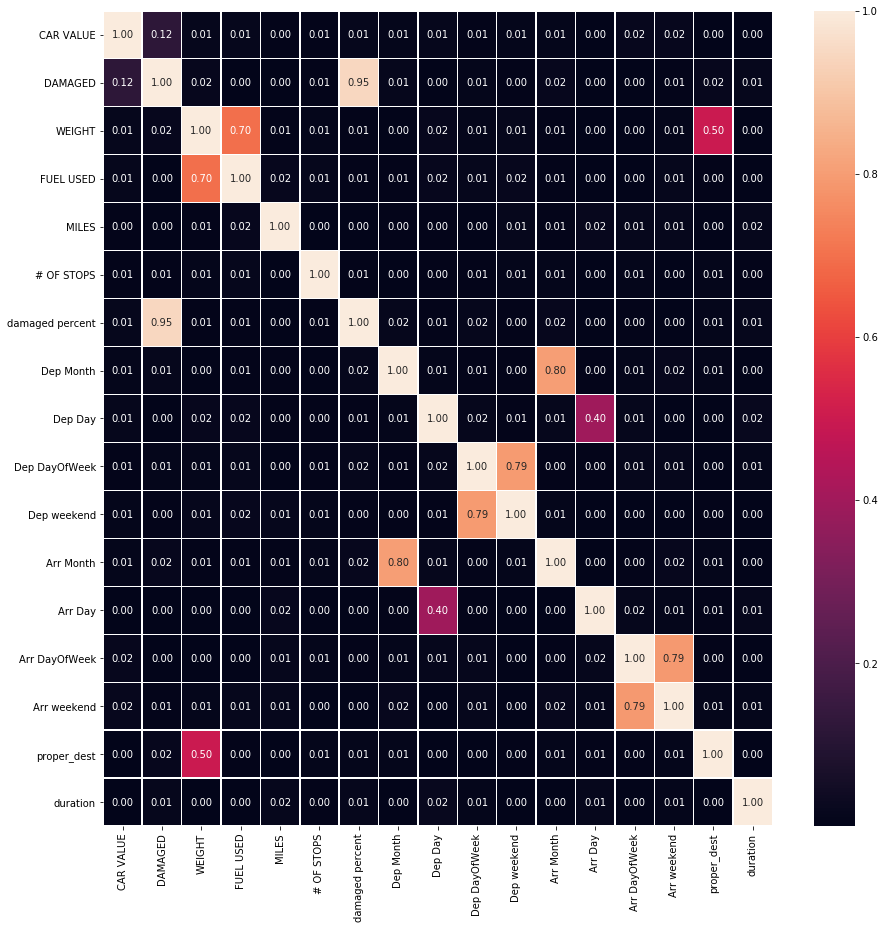

In [108]:
c_m = data.corr()
plt.figure(figsize=(15, 15))
sns.heatmap(np.abs(c_m), annot=True, fmt=".2f", linewidths=.5)

Видна корреляция между днем отправления и днем прибытия, месяцем отправления и месяцем прибытия, что говорит о наличии расписания, корреляция между днем недели и выходным также ясна, как и между использованным топливом и весом груза. Интересна корреляция между правильным направлением и весом, нуждается в доп. изучении. Видно, что добавленные признаки немного коррелируют с целевой переменной. Переменную DAMAGED нужно удалить, она может быть получена из CAR VALUE и damaged percent.

In [109]:
data.drop(['DAMAGED'], axis=1, inplace=True)

Отобразим плотности распределения числовых величин и колличество значений категориальных:

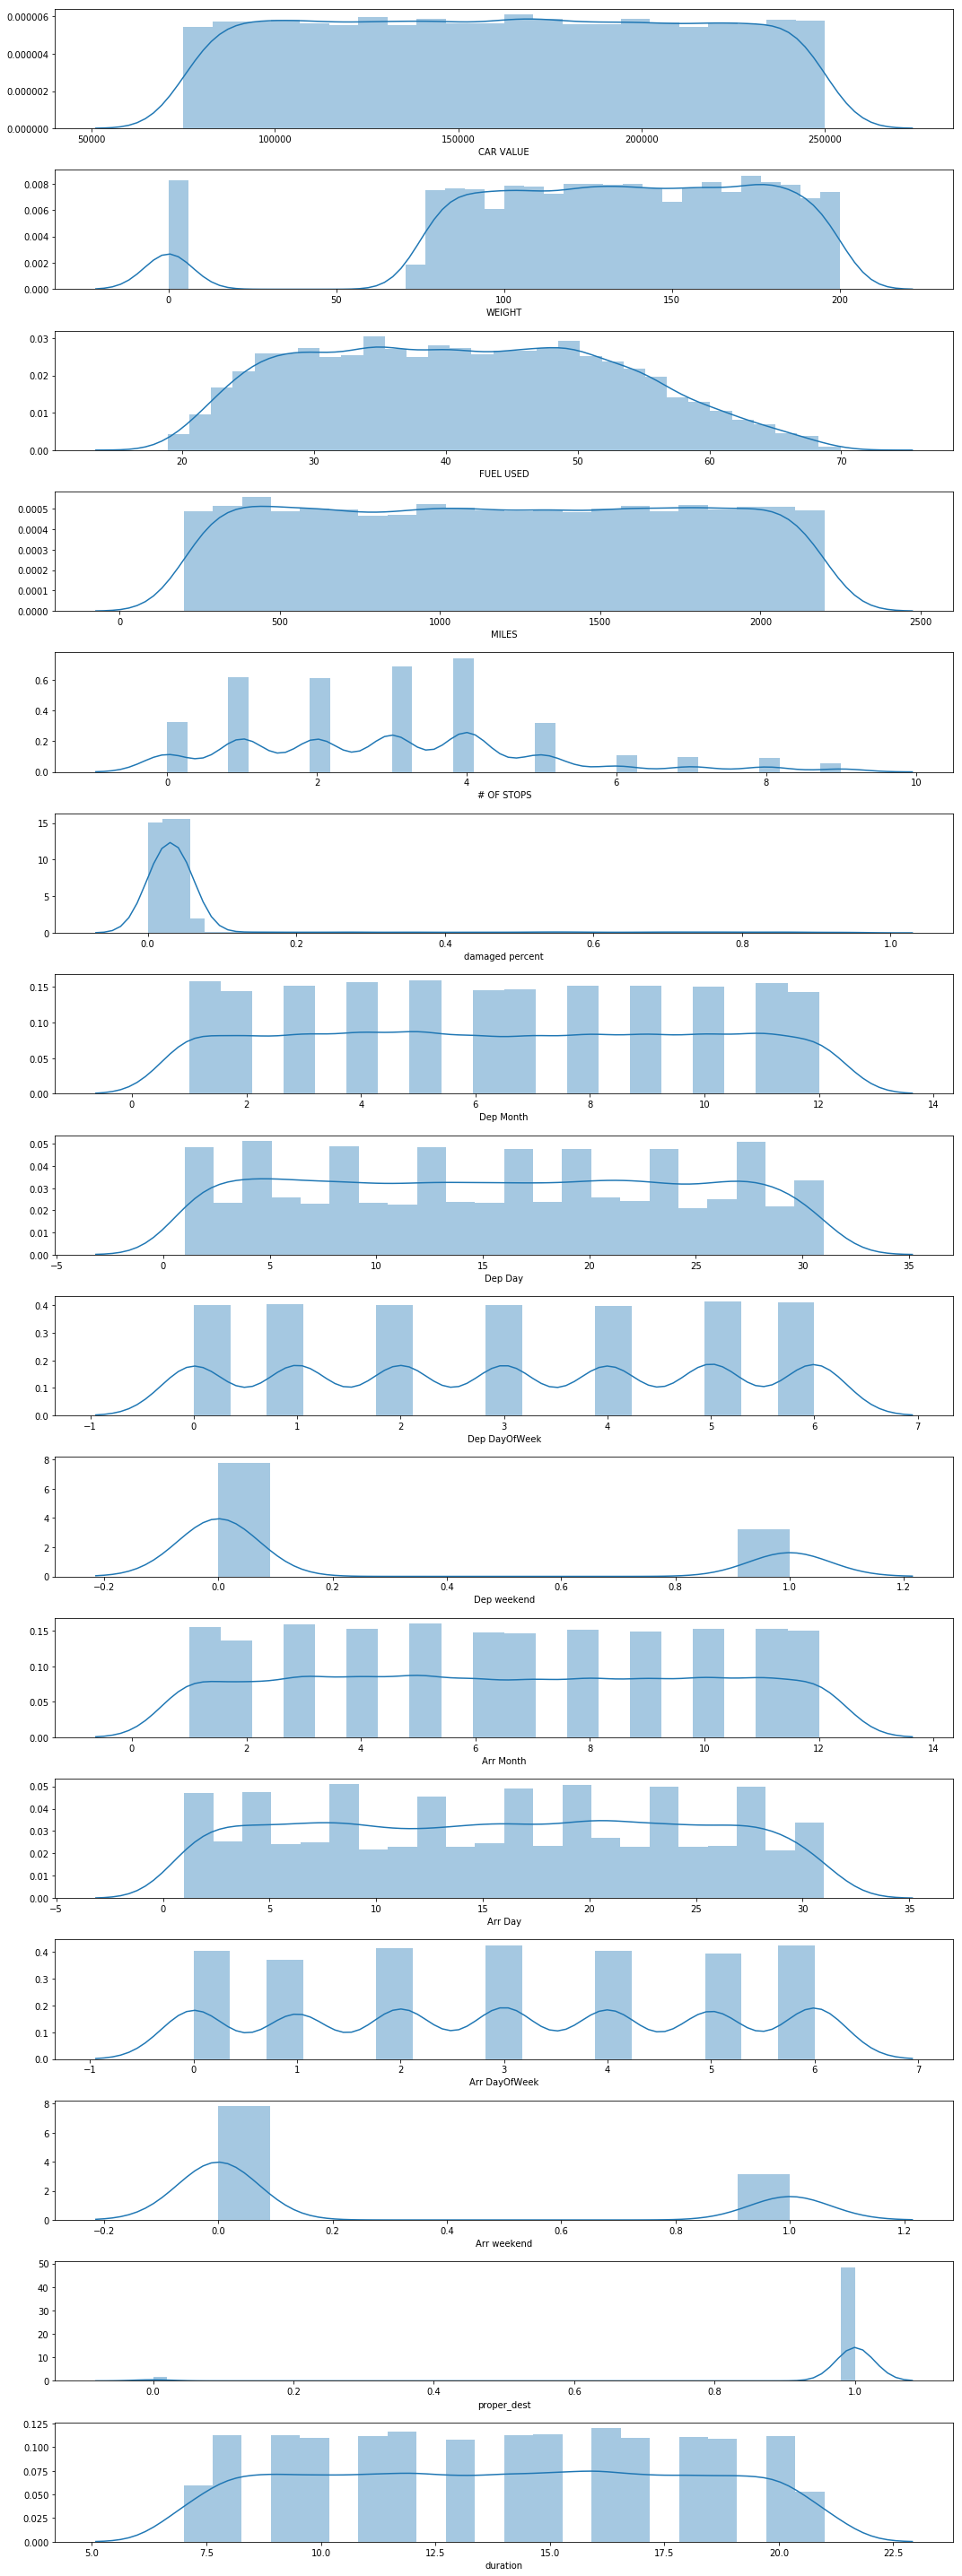

In [110]:
clmns = data.select_dtypes(exclude=['object','datetime64', 'bool']).columns
f, axarr = plt.subplots(ncols=1, nrows=len(clmns), figsize=(15, 40))

for c in clmns:
    sns.distplot(data[c], ax=axarr[list(clmns).index(c)])

plt.tight_layout()

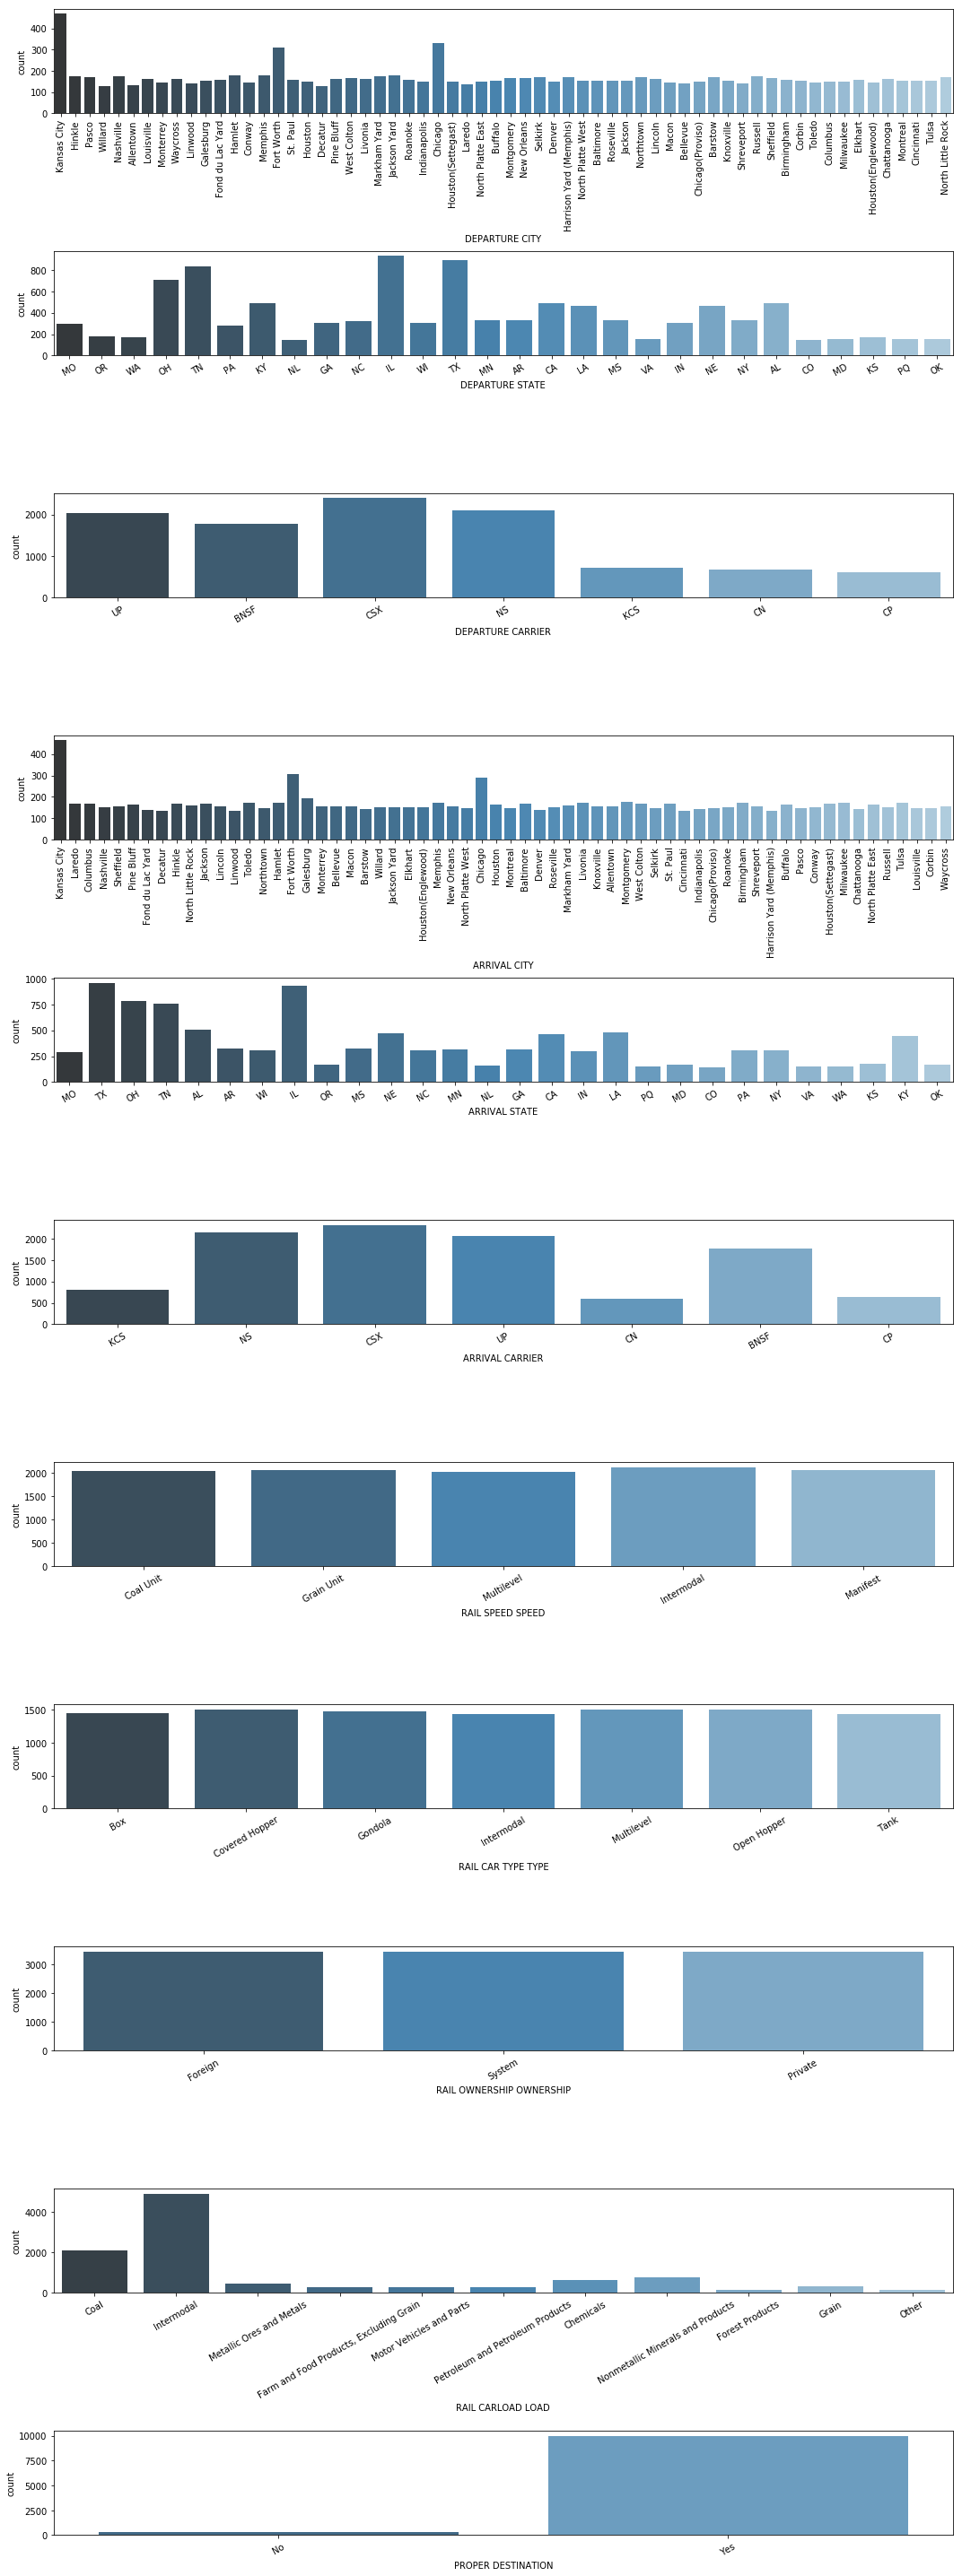

In [111]:
categories = data.select_dtypes('object').columns

f, axarr = plt.subplots(ncols=1, nrows=len(categories), figsize=(15, 40))

i = 0
for cat in categories:
    g = sns.countplot(x=cat, data=data, ax=axarr[i], palette="Blues_d")
    
    r = 30
    if (cat.endswith('CITY')):
        r = 90
    g.set_xticklabels(g.get_xticklabels(), rotation=r)
    
    i += 1
plt.tight_layout(h_pad=0.5)
    

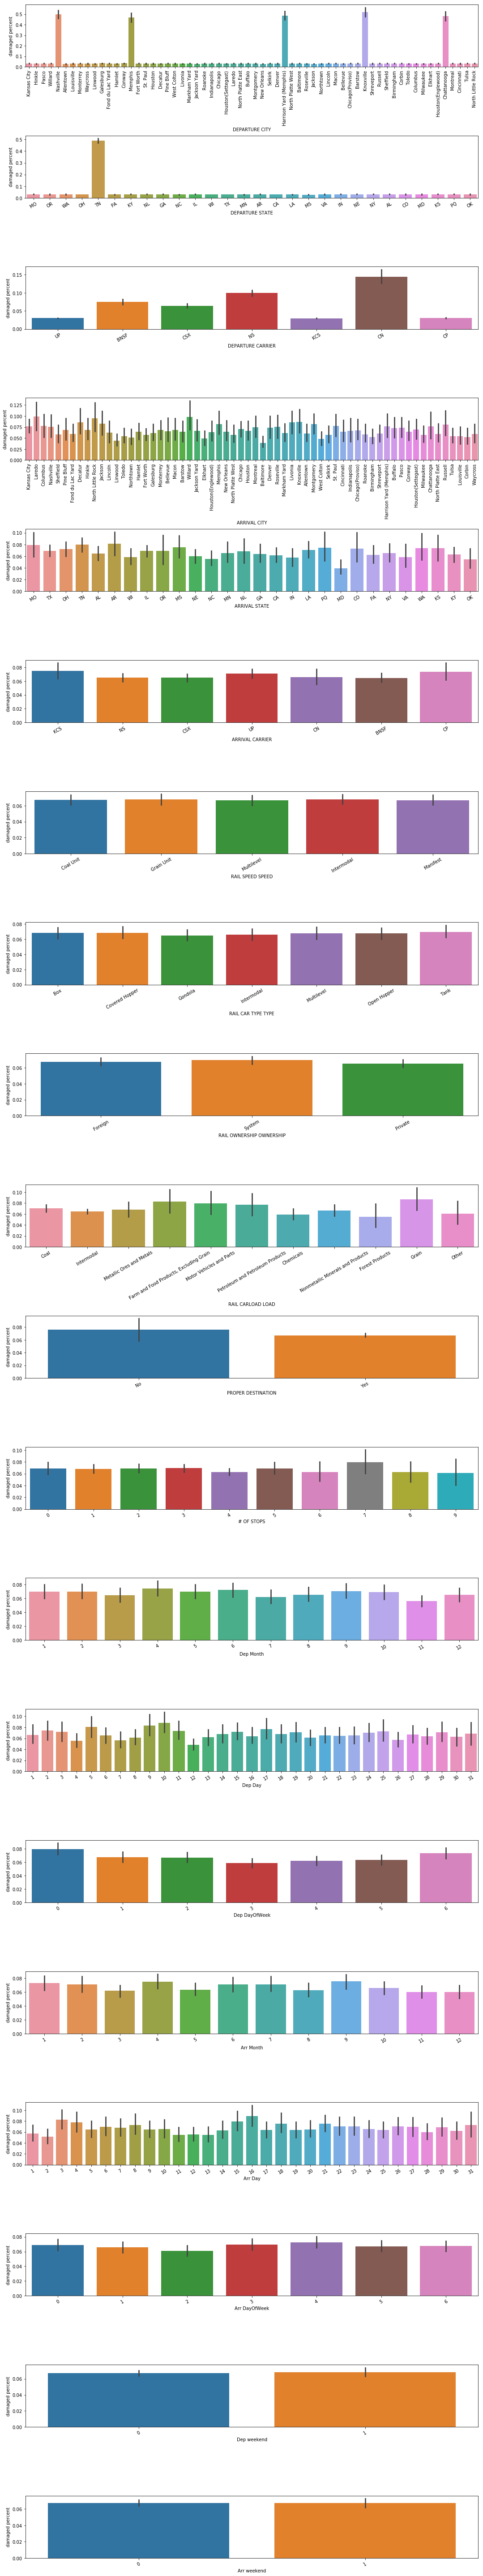

In [112]:
categories = list(data.select_dtypes('object').columns) + ['# OF STOPS', 'Dep Month', 'Dep Day', 'Dep DayOfWeek', 'Arr Month', 'Arr Day', 'Arr DayOfWeek', 'Dep weekend', 'Arr weekend']

f, axarr = plt.subplots(ncols=1, nrows=len(categories), figsize=(15, 80))

i = 0
for cat in categories:
    g = sns.barplot(x=cat, y='damaged percent', data=data, ax=axarr[i])
    
    r = 30
    if (cat.endswith('CITY')):
        r = 90
    g.set_xticklabels(g.get_xticklabels(), rotation=r)
    
    i += 1
plt.tight_layout(h_pad=0.5)
    

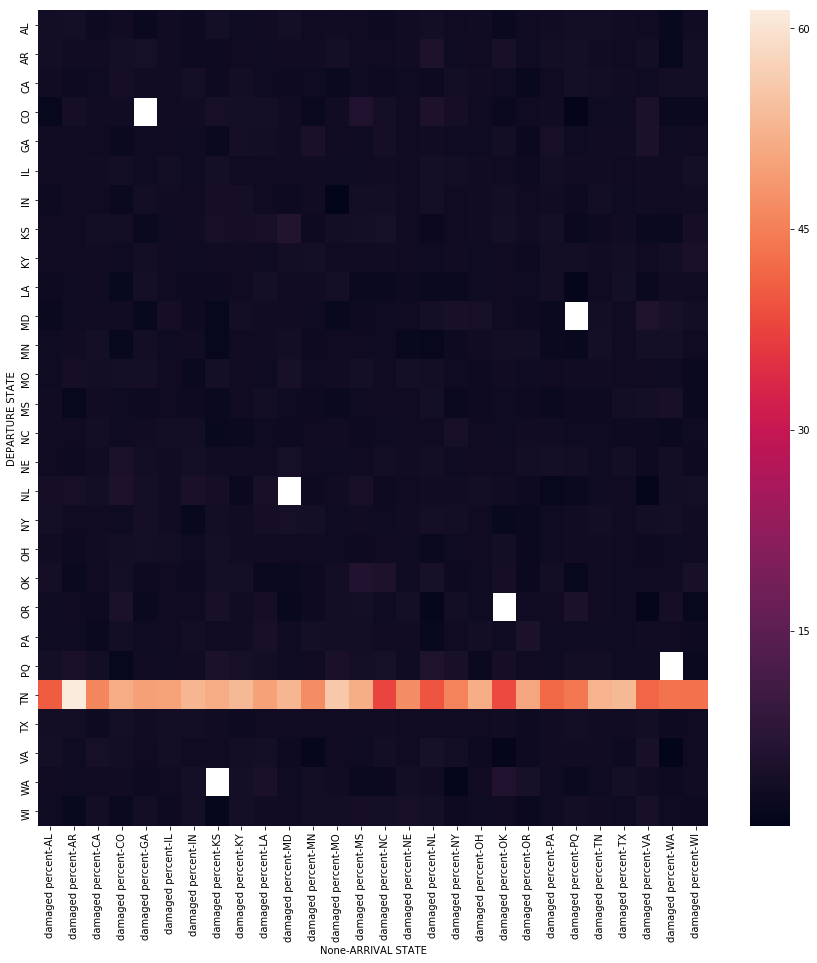

In [113]:
state_tbl = (data.pivot_table(['damaged percent'], ['DEPARTURE STATE'], ['ARRIVAL STATE'], aggfunc='mean')) * 100

plt.figure(figsize=(15, 15))
sns.heatmap(state_tbl)

#### Выводы
Видно, что результаты визуального анализа отображают закономерности, выявленные в предыдущей части. Распределения величин не указывает на наличие выбросов. Почти все значения признаков имеют разные средние значения damaged percent, т.е. должны быть учтены при прогнозе.

### 4. Инсайты и закономерности

Часть закономерностей описана выше.
Следует также создать признаки, связанные с путем, закодировать некоторые из них OHE, для путей как таковых применить mean target encoding.

### 5. Выбор метрики и модели

Т.к. в данных нет выбросов, а решаемая задача - регрессия, можно использовать MSE или R2. Т.к. R2 - это по сути 1 - усредненная MSE, то используем первую для большей наглядности. 

В качестве модели будем сравнивать линейную регрессию и градиентный бустинг, т.к. они обе подходят для задачи регрессии, а градиентный бустинг хорошо себя зарекомендовал в решениях задач со смешанным типом признаков. При использовании линейной регрессии будем масштабировать признаки.

### 6. Предобработка данных и создание новых признаков

Частично предобработка была выполнена выше для визуализации.

Создадим признаки, связанные с путем:

In [114]:
data['interstate'] = (data['DEPARTURE STATE'] != data['ARRIVAL STATE']).astype('int')
data['intercity'] = (data['DEPARTURE CITY'] != data['ARRIVAL CITY']).astype('int')
data['intercarrier'] = (data['DEPARTURE CARRIER'] != data['ARRIVAL CARRIER']).astype('int')

In [115]:
data['city route'] = data['DEPARTURE CITY'] + data['ARRIVAL CITY']
data['state route'] = data['DEPARTURE STATE'] + data['ARRIVAL STATE']
data['carrier route'] = data['DEPARTURE CARRIER'] + data['ARRIVAL CARRIER']

Создадим относительный признак расход доплива: 

In [116]:
data['FUEL PER MILE'] = (data['FUEL USED']/data['MILES'])

Напишем функцию для кодирования средним:

In [117]:
def mean_target_enc(train_df, y_train, valid_df, cat_features, skf):
    import warnings
    warnings.filterwarnings('ignore')
    target_name = y_train.name
    
    glob_mean = y_train.mean()
    train_df = pd.concat([train_df, pd.Series(y_train, name='y')], axis=1)
    new_train_df = train_df.copy()  

    for col in cat_features:
        new_train_df[col + '_mean_' + target_name] = [glob_mean for _ in range(new_train_df.shape[0])]

    for train_idx, valid_idx in skf.split(train_df, y_train):
        train_df_cv, valid_df_cv = train_df.iloc[train_idx, :], train_df.iloc[valid_idx, :]

        for col in cat_features:
            
            means = valid_df_cv[col].map(train_df_cv.groupby(col)['y'].mean())
            valid_df_cv[col + '_mean_' + target_name] = means.fillna(glob_mean)
            
        new_train_df.iloc[valid_idx] = valid_df_cv
    
    new_train_df.drop(['y'], axis=1, inplace=True)
    
    for col in cat_features:
        means = valid_df[col].map(train_df.groupby(col)['y'].mean())
        valid_df[col + '_mean_' + target_name] = means.fillna(glob_mean)
        
#     valid_df.drop(cat_features, axis=1, inplace=True)
    
    return new_train_df, valid_df

Применим OHE преобразование к категориальным признакам, за исключением путей:

In [118]:
data_ohe = pd.get_dummies(data, columns=['DEPARTURE CITY', 'DEPARTURE STATE', 'DEPARTURE CARRIER',
       'ARRIVAL CITY', 'ARRIVAL STATE', 'ARRIVAL CARRIER', 'RAIL SPEED SPEED',
       'RAIL CAR TYPE TYPE', 'RAIL OWNERSHIP OWNERSHIP', 'RAIL CARLOAD LOAD'])

Применим mean target encoding к путям

In [119]:
data_ohe, _ = mean_target_enc(data_ohe, (data['damaged percent']*10000).astype('int'), data_ohe[-1:], ['city route', 'state route', 'carrier route'], StratifiedKFold(5, shuffle=True, random_state=17))

Удалим ненужные фичи и выделим целевую переменную:

In [120]:
y = data['damaged percent']
data_ohe.drop(['DEPEARTURE DATE', 'ARRIVAL DATE', 'FUEL USED', 'city route', 'state route', 'carrier route', 'PROPER DESTINATION'], axis=1, inplace=True)

In [121]:
data_ohe.drop(['damaged percent'], axis=1, inplace=True)

((array([-3.81841229, -3.59369394, -3.47034224, ...,  3.47034224,
          3.59369394,  3.81841229]),
  array([9.09268856e-06, 1.02981738e-05, 2.26812624e-05, ...,
         9.57661841e-01, 9.58842587e-01, 9.59327769e-01])),
 (0.0904392006358875, 0.0674439287270921, 0.6105744617075064))

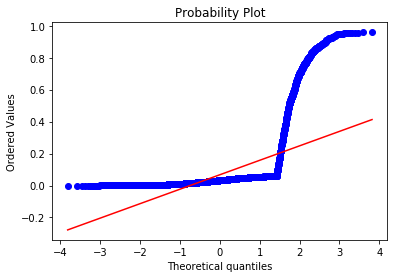

In [122]:

import scipy.stats as stats

stats.probplot(y, dist="norm", plot=plt)

((array([-3.81841229, -3.59369394, -3.47034224, ...,  3.47034224,
          3.59369394,  3.81841229]),
  array([-11.60803992, -11.48354397, -10.69397142, ...,  -0.04326055,
          -0.04202836,  -0.04152248])),
 (1.1838713189608188, -3.5705920013320553, 0.951673698469864))

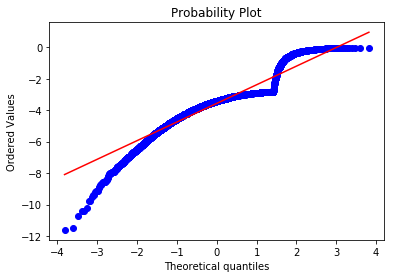

In [123]:

stats.probplot(np.log(y), dist="norm", plot=plt)

((array([-3.81841229, -3.59369394, -3.47034224, ...,  3.47034224,
          3.59369394,  3.81841229]),
  array([-0.45542541, -0.45541727, -0.45533364, ...,  6.01214267,
          6.02011691,  6.02339362])),
 (0.6107868305751062, -1.8838056894899562e-16, 0.6105744617075064))

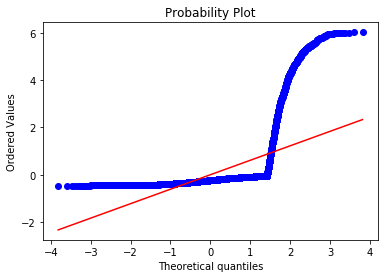

In [124]:

stats.probplot(StandardScaler().fit_transform(y.values.reshape(-1,1).astype(np.float64)).flatten(), dist="norm", plot=plt)

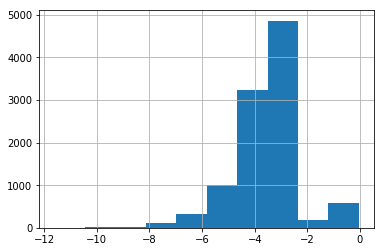

In [140]:
y = np.log(y)
y.hist()

Выделим тренировочную, валидационную и тестовые выборки. Т.к. данные у нас сбалансированы, выберем случайный способ. Отмасштабируем признаки.

In [126]:

st = StandardScaler()

X_train, X_val, y_train, y_val = train_test_split(data_ohe, y, test_size=0.3, random_state=1)
X_train_st = st.fit_transform(X_train)
X_val_st = st.transform(X_val)

X_val_st, X_test_st, y_val, y_test = train_test_split(X_val_st, y_val, test_size=0.3333, random_state=1)

In [131]:
lr = LinearRegression(n_jobs=-1)

cv_sc = cross_val_score(lr, X_train, y_train,  cv=5, n_jobs=-1)


In [132]:
cv_sc

array([0.71648174, 0.6512127 , 0.71581048, 0.73796589, 0.75419857])

In [133]:
lr.fit(X_train, y_train)
lr_pred_val = lr.predict(X_val_st)

r2_score(y_val, lr_pred_val)


-425066626133812.0

In [146]:
lr_test_pred = lr.predict((X_test_st))
print(r2_score(y_test, lr_test_pred))
np.sqrt(mean_squared_error(y_test, lr_test_pred))

-476287409868400.9


3047705.790644471

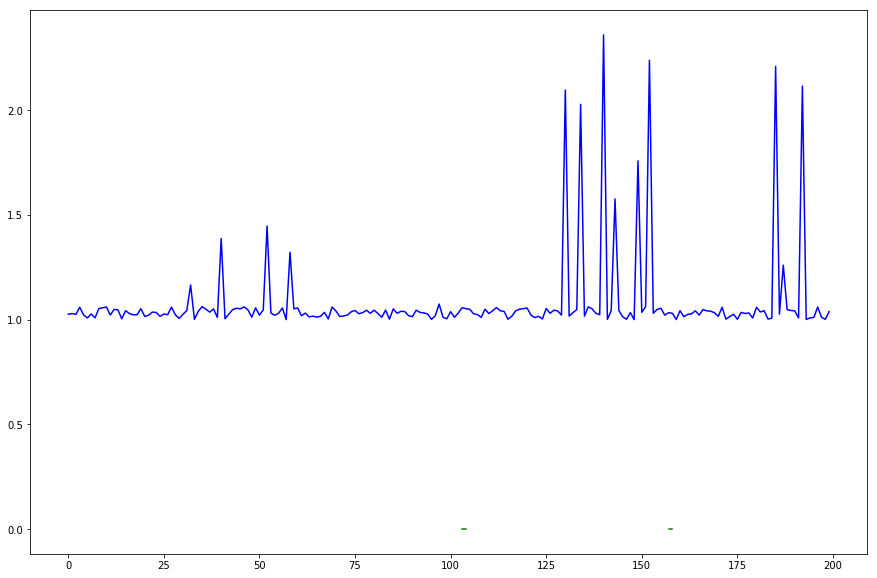

In [147]:
plt.figure(figsize=(15, 10))
plt.plot(np.exp(y_test).values[-200:], 'b')
plt.plot(np.exp(lr_test_pred)[-200:], 'g')

Видим, что линейная регрессия не сработала. Посмотрим на xboost.

In [134]:


dtrain = xgb.DMatrix(X_train_st, label=np.sqrt(y_train))
dtest = xgb.DMatrix(X_val_st)

params = {
    'objective':'reg:linear',
    'max_depth':5,
    'silent':1,
    'nthread': 8,
#     'booster': 'dart',
#     'eta':0.5,
#     'gamma': 0.1,
#     'lambda': 20,
#     'alpha': 0.5
}

num_rounds = 100
xgb_ = xgb.train(params, dtrain, num_rounds)

xgb__pred = xgb_.predict(dtest)

r2_score(y_val, (xgb__pred))

-0.24015561637284955

In [135]:

np.sqrt(mean_squared_error(np.sqrt(y_val), xgb__pred))

0.09428229633789344

In [136]:

np.sqrt(mean_squared_error(y_val, np.exp(xgb__pred)))

1.1861344582680957

In [144]:
xgb_test_pred = xgb_.predict(xgb.DMatrix(X_test_st))
print(r2_score(y_test, xgb_test_pred))
np.sqrt(mean_squared_error(y_test, xgb_test_pred))

-0.277636144649843


0.1578490906161627

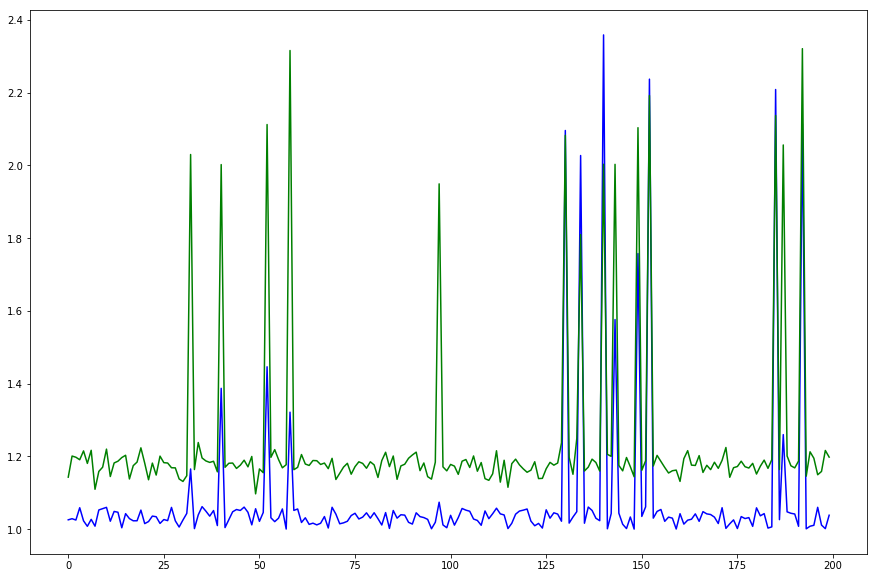

In [145]:
plt.figure(figsize=(15, 10))
plt.plot(np.exp(y_test).values[-200:], 'b')
plt.plot(np.exp(xgb_test_pred)[-200:], 'g')

А xgboost справляется неплохо, но предсказания получились смещенными вверх.

### Выводы:

Удалось проанализировать датасет с вполне приемлемыми результатами. Линейная регрессия плохо показала себя в этой задаче, а градиентный бустинг - довольно хорошо. 

Для улучшения результатов можно выделить больше признаков или закодировать средним больше категориальных фич. Также можно преобразовать задачу в бинарную классификацию, определяя обычные и большие убытки. 

Используя полученную модель, можно довольно хорошо предсказывать крупные потери при траспортировке, что будет полезно как страховым компаниям, так и перевозчикам.